# Import thư viện cần thiết

In [82]:
import pandas as pd
import sqlite3 as lite
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyarrow as pa
import pyarrow.json as pj
import pyarrow.parquet as pq

In [83]:
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_squared_log_error, make_scorer

# Tiền xử lý
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# Thư viện scikit-learn cho học máy
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

# Các mô hình máy học tuyến tính
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LassoLarsCV, Lasso

# Mô hình phi tuyến
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, VotingRegressor

from sklearn.model_selection import GridSearchCV

# Mô hình xgb
import xgboost as xgb


In [377]:
from sklearn.inspection import permutation_importance

In [84]:
pd.options.display.max_columns=0

In [85]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
#@markdown To access data saved on Shared Folder, add them to "My drive" as shortcut first
root_path="/content/drive/My Drive/" #@param {type:"string"}
_root = Path(root_path)
#!ls "$root_path"

# Load dữ liệu

In [87]:
#@markdown Connect to sqlite3 database (which reside on Google Drive)
# Create parent path to the DB first if not exist
_db_path = _root.joinpath("Main.db")
Path(_db_path).parent.mkdir(parents=True, exist_ok=True)

try:
    conn = lite.connect(_db_path)
    print(f"sqlite3 {lite.version} has connected to database successfully")
except lite.Error as e:
    print("Error: ", e)

sqlite3 2.6.0 has connected to database successfully


In [88]:
#Tải các bảng dữ liệu cần thiết, tuy nhiên, có thể thay đổi data source của các bảng. VD: parquet
dim_foody_audience =pd.read_sql('SELECT * FROM DIM_FOODY_AUDIENCE',conn)
dim_foody_category =pd.read_sql('SELECT * FROM DIM_FOODY_CATEGORY',conn)
dim_active_hours =pd.read_sql('SELECT * FROM DIM_ACTIVE_HOURS',conn)
dim_foody_cuisine =pd.read_sql('SELECT * FROM DIM_FOODY_CUISINE',conn)
dim_shopee_brand =pd.read_sql('SELECT * FROM DIM_SHOPEE_BRAND',conn)
dim_shopee_category =pd.read_sql('SELECT * FROM DIM_SHOPEE_CATEGORY',conn)
dim_shopee_cuisine =pd.read_sql('SELECT * FROM DIM_SHOPEE_CUISINE',conn)
dim_shopee_dishes =pd.read_sql('SELECT * FROM DIM_SHOPEE_DISHES',conn)
dim_shopee_root_category =pd.read_sql('SELECT * FROM DIM_SHOPEE_ROOT_CATEGORY',conn)
restaurant =pd.read_sql('SELECT * FROM RESTAURANT',conn)

# 1. Khám phá dữ liệu

## 1.1 Các bảng

### 1.1.1 Audience

In [89]:
dim_foody_audience.head()

,restaurant_id,audience
0,2,Cặp đôi
1,2,Nhóm hội
2,2,Giới Manager
3,2,Giới văn phòng
4,14,Khách du lịch


In [90]:
dim_foody_audience.shape

(156984, 2)

In [91]:
dim_foody_audience['audience'].value_counts()

Nhóm hội          37192
Giới văn phòng    32214
Gia đình          28940
Sinh viên         21669
Cặp đôi           17245
Trẻ em             7659
Khách du lịch      6265
Giới Manager       5800
Name: audience, dtype: int64

In [92]:
dim_foody_audience=dim_foody_audience.drop_duplicates()
dim_foody_audience['count']=1

dim_foody_audience=dim_foody_audience.pivot(index='restaurant_id', columns='audience',values='count').reset_index().fillna(0).rename_axis(None, axis=1)
dim_foody_audience.columns=['restaurant_id', 'au_couple', 'au_family', 'au_manager','au_officer', 'au_traveler', 'au_team', 'au_student', 'au_childen']

dim_foody_audience[['au_couple', 'au_family', 'au_manager','au_officer', 'au_traveler', 'au_team', 'au_student', 'au_childen']]=\
dim_foody_audience[['au_couple', 'au_family', 'au_manager','au_officer', 'au_traveler', 'au_team', 'au_student', 'au_childen']].astype(bool)

<ipython-input-92-35fc501135ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dim_foody_audience['count']=1


In [93]:
dim_foody_audience

,restaurant_id,au_couple,au_family,au_manager,au_officer,au_traveler,au_team,au_student,au_childen
0,2,True,False,True,True,False,True,False,False
1,14,False,True,False,False,True,False,False,False
2,30,False,True,False,True,False,True,True,False
3,93,False,True,False,True,False,True,False,False
4,283,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
41480,1000059098,True,True,True,True,True,True,True,True
41481,1000059102,True,True,True,True,True,True,True,True
41482,1000059112,False,False,False,True,False,True,True,True
41483,1000059115,True,True,True,True,True,True,True,True


### 1.1.2 Category

In [94]:
dim_shopee_category.head()

,restaurant_id,category
0,2,Restaurant
1,14,Restaurant
2,14,Luxury
3,30,Restaurant
4,50,Coffee/Dessert


In [95]:
dim_shopee_category['category'].value_counts().index
# xử lý sau vì quá nhiều value

Index(['Bistro', 'Coffee/Dessert', 'Street food', 'Shop Online', 'Restaurant',
       'Bakery', 'Vegetarian', 'Boozer', 'Office lunch delivery', 'Foodcourt',
       'Shop/Stores', 'Luxury', 'Bar/Pub', 'Catering', 'Buffet', 'Market',
       'Online Shopping', 'Beer club', 'Wedding/Convention', 'Supermarket',
       'Gaming Zone', 'Pets', 'Beauty shop', 'Shop', 'Cinema',
       'Cleaning Service', 'Sport Club', 'Billiards', 'Wedding flowers',
       'Sight & Landmark', 'Nail salon', 'Tattoo', 'Theater', 'Spa/Massage',
       'Homestay', 'Karaoke', 'University & College'],
      dtype='object')

In [96]:
dim_foody_category.head()

,restaurant_id,category
0,1059918,Quán ăn
1,1074507,Quán ăn
2,940085,Quán ăn
3,1033536,Quán ăn
4,762984,Quán ăn


In [97]:
dim_foody_category['category'].value_counts().index
# xử lý sau vì quá nhiều value

Index(['Quán ăn', 'Café/Dessert', 'Ăn vặt/vỉa hè', 'Shop Online', 'Nhà hàng',
       'Tiệm bánh', 'Ăn chay', 'Quán nhậu', 'Giao cơm văn phòng', 'Sang trọng',
       'Khu Ẩm Thực', 'Shop/Cửa hàng', 'Buffet', 'Bar/Pub', 'Tiệc tận nơi',
       'Beer club', 'Shop hóa mỹ phẩm', 'Siêu thị'],
      dtype='object')

### 1.1.3 Cuisine

In [98]:
dim_shopee_cuisine.head()

,restaurant_id,cuisine
0,920007,Vietnam
1,803070,Vietnam
2,743816,Vietnam
3,25014,Vietnam
4,725119,Vietnam


In [99]:
dim_shopee_cuisine['cuisine'].value_counts().index
# xử lý sau vì quá nhiều value

Index(['Vietnam', 'South', 'Asian', 'North', 'Central', 'Western', 'Chinese',
       'Korean', 'Japanese', 'International', 'Special', 'American', 'Taiwan',
       'Italian', 'Thailand', 'USA', 'Hanoi', 'Hue', 'Singapore', 'Highlands',
       'French', 'Eastern Europe', 'Southwest', 'Turkey', 'Southeast',
       'Central Cuisine', 'Nha Trang', 'Zoom special', 'Indian', 'Da Lat',
       'Pizza', 'Binh Dinh', 'Malaysia', 'Middle East', 'Cambodia',
       'Philippines', 'German', 'Nam Dinh', 'African', 'Nordic', 'Australian',
       'Mexican', 'Arabian', 'Canadian', 'Northwest', 'Spanish',
       'Buon Me Thuot', 'Czech', 'Brazilian', 'Iranian', 'Switzerland'],
      dtype='object')

In [100]:
dim_foody_cuisine.head()

,restaurant_id,cuisine
0,2,Món Nhật
1,14,Quốc tế
2,14,Món Việt
3,30,Singapore
4,50,Món Việt


In [101]:
dim_foody_cuisine['cuisine'].value_counts().index
# xử lý sau vì quá nhiều value

Index(['Món Việt', 'Món Miền Nam', 'Món Miền Trung', 'Món Bắc', 'Tây Nguyên',
       'Món Trung Hoa', 'Món Hàn', 'Món Á', 'Món Nhật', 'Quốc tế', 'Đặc biệt',
       'Món Âu', 'Đài Loan', 'Đặc sản vùng', 'Món Thái', 'Ý', 'Mỹ', 'Hà Nội',
       'Singapore', 'Món Huế', 'Pháp', 'Miền Tây', 'Thổ Nhĩ Kỳ', 'Bánh Pizza',
       'Châu Mỹ', 'Miền Đông', 'Nam Định', 'Món Quảng', 'Nha Trang',
       'Món Ấn Độ', 'Tây Bắc', 'Malaysia', 'Úc', 'Bắc Âu', 'Campuchia',
       'Trung Đông', 'Đức', 'Mexico', 'Philippines', 'Đà Lạt', 'Châu Phi',
       'Đông Âu', 'Bình Định', 'Canada', 'Indonesia', 'Tây Ban Nha', 'Ả Rập',
       'Thụy sĩ', 'Brazil', 'Iran', 'Argentina', 'Tiệp (Séc)', 'Buôn Mê'],
      dtype='object')

### 1.1.4 Root category

In [102]:
dim_shopee_root_category.head()

,restaurant_id,root_category_ids
0,2,2387
1,2,2546
2,2,2389
3,2,2426
4,14,2419


In [103]:
dim_shopee_root_category['root_category_ids'].value_counts().index
# xử lý sau vì quá nhiều value

Int64Index([2387, 2388, 2448, 2426, 2410, 2546, 2455, 2414, 2391, 2419,
            ...
             129,  108,  139,  137, 2478,  136,  167,  111, 2501, 1715],
           dtype='int64', length=152)

### 1.1.5 Active hours

In [104]:
dim_active_hours

,restaurant_id,week_day,active_hour
0,14,1,10
1,14,1,11
2,14,1,12
3,14,1,13
4,14,1,14
...,...,...,...
4039618,1123133,7,16
4039619,1123133,7,17
4039620,1123133,7,18
4039621,1123133,7,19


In [105]:
x=dim_active_hours.groupby('restaurant_id').count().reset_index()[['restaurant_id','active_hour']]
x['active_hour']=x['active_hour']/24/7
x

,restaurant_id,active_hour
0,2,0.416667
1,14,0.500000
2,30,0.458333
3,50,0.583333
4,73,0.625000
...,...,...
50631,1000059098,0.458333
50632,1000059102,0.625000
50633,1000059112,1.000000
50634,1000059115,0.416667


In [106]:
hy=dim_active_hours.groupby(['restaurant_id','active_hour']).count().unstack(level=1)/7
hy=hy.reset_index()
hy=hy.rename(columns={'week_day':'active_week_day_ratio'})
hy.columns=[y[0] + str(y[1]) for y in  hy.columns]
hy=hy.fillna(0)

In [107]:
hy['is_daytime']=False
hy['is_eveningtime']=False
hy['is_nighttime']=False
hy.loc[
    hy['active_week_day_ratio6']\
    +hy['active_week_day_ratio7']\
    +hy['active_week_day_ratio8']\
    +hy['active_week_day_ratio9']\
    +hy['active_week_day_ratio10']\
    +hy['active_week_day_ratio11']\
    +hy['active_week_day_ratio12']\
    +hy['active_week_day_ratio13']\
    +hy['active_week_day_ratio14']\
    +hy['active_week_day_ratio15']\
    +hy['active_week_day_ratio16']\
    >6
,'is_daytime']=True

hy.loc[
    hy['active_week_day_ratio17']\
    +hy['active_week_day_ratio18']\
    +hy['active_week_day_ratio19']\
    +hy['active_week_day_ratio20']\
    +hy['active_week_day_ratio21']\
    +hy['active_week_day_ratio22']\
    >3
,'is_eveningtime']=True

hy.loc[
    hy['active_week_day_ratio23']\
    +hy['active_week_day_ratio0']\
    +hy['active_week_day_ratio1']\
    +hy['active_week_day_ratio2']\
    +hy['active_week_day_ratio3']\
    +hy['active_week_day_ratio4']\
    >3\
,'is_nighttime']=True
hy=hy[['restaurant_id','is_daytime','is_eveningtime','is_nighttime']]

In [108]:
dim_active_hours=x.merge(hy,on='restaurant_id').rename({'active_hour':'weekly_active_hour_ratio'})

In [109]:
dim_active_hours

,restaurant_id,active_hour,is_daytime,is_eveningtime,is_nighttime
0,2,0.416667,True,False,False
1,14,0.500000,True,True,False
2,30,0.458333,False,True,False
3,50,0.583333,True,True,False
4,73,0.625000,True,True,False
...,...,...,...,...,...
50631,1000059098,0.458333,True,True,False
50632,1000059102,0.625000,True,True,False
50633,1000059112,1.000000,True,True,True
50634,1000059115,0.416667,False,True,False


### 1.1.6 Brand

In [110]:
dim_shopee_brand=dim_shopee_brand[['brand_id','restaurant_count']]
dim_shopee_brand

,brand_id,restaurant_count
0,282,76
1,11148,2
2,5605,2
3,53,2
4,261,1
...,...,...
4371,12334,3
4372,14511,23
4373,15068,4
4374,15541,2


### 1.1.7 Dishes

In [111]:
dim_shopee_dishes.head()

,catalog_id,dish_total_order,catalog_name,catalog_rank,catalog_partner_catalog_id,catalog_description,dish_restaurant_id,dish_id,dish_name,dish_partner_dish_id,dish_listing_status,dish_description,dish_total_like,dish_rank,dish_picture_label,dish_is_hidden,dish_price,dish_is_group_discount_item,dishes_property_info,url
0,2635001,160.0,Món Hot,-11.0,None,None,1114911.0,46050027.0,Trà Đào,None,1,Trà đào kèm miếng đào tươi,4.0,0.0,None,0,24000.0,1,"{""has_alcohol"": false}",https://images.foody.vn/res/g112/1114911/s1242...
1,2635001,136.0,Món Hot,-11.0,None,None,1114911.0,28885958.0,Trà Sữa Nọng Xanh,None,1,Trà Sữa Nọng Xanh là trà sữa vị thái xanh đã b...,55.0,0.0,None,0,24000.0,1,"{""has_alcohol"": false}",https://images.foody.vn/res/g103/1025330/s1242...
2,2635001,126.0,Món Hot,-11.0,None,None,1114911.0,46050017.0,Trà Vải,None,1,Trà vải tươi mát kèm trái vải,3.0,0.0,None,0,24000.0,1,"{""has_alcohol"": false}",https://images.foody.vn/res/g112/1114911/s1242...
3,2635001,4.0,Món Hot,-11.0,None,None,1114911.0,121626885.0,Cà Phê Sữa Tươi Hạnh Nhân Phin Di,None,1,None,0.0,0.0,None,0,29000.0,1,"{""has_alcohol"": false}",None
4,2635001,4.0,Món Hot,-11.0,None,None,1114911.0,121637344.0,Sữa Tươi Trân Châu Đường Đen HQ,None,1,None,0.0,0.0,None,0,35000.0,1,"{""has_alcohol"": false}",None


In [112]:
d_price=dim_shopee_dishes[['dish_restaurant_id','dish_price']].groupby('dish_restaurant_id').mean()

d_min_price=dim_shopee_dishes[['dish_restaurant_id','dish_price']].groupby('dish_restaurant_id').min()
d_min_price.rename(columns={'dish_price':'dish_min_price'},inplace=True)

d_max_price=dim_shopee_dishes[['dish_restaurant_id','dish_price']].groupby('dish_restaurant_id').max()
d_max_price.rename(columns={'dish_price':'dish_max_price'},inplace=True)

d_order=dim_shopee_dishes[['dish_restaurant_id','dish_total_order']].groupby('dish_restaurant_id').sum()
d_like=dim_shopee_dishes[['dish_restaurant_id','dish_total_like']].groupby('dish_restaurant_id').sum()

d_revenue=dim_shopee_dishes[['dish_restaurant_id','dish_total_order','dish_price']]
d_revenue['revenue']=d_revenue['dish_total_order']*d_revenue['dish_price']
d_revenue=d_revenue[['dish_restaurant_id','revenue']].groupby('dish_restaurant_id').sum()


dim_shopee_dishes=d_price\
                    .merge(d_order, on='dish_restaurant_id')\
                    .merge(d_like,on='dish_restaurant_id')\
                    .merge(d_min_price,on='dish_restaurant_id')\
                    .merge(d_max_price,on='dish_restaurant_id')\
                    .merge(d_revenue,on='dish_restaurant_id')\
                    .reset_index()
dim_shopee_dishes['dish_restaurant_id']=dim_shopee_dishes['dish_restaurant_id'].astype('int64')

<ipython-input-112-41128e4fb096>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_revenue['revenue']=d_revenue['dish_total_order']*d_revenue['dish_price']


In [113]:
dim_shopee_dishes

,dish_restaurant_id,dish_price,dish_total_order,dish_total_like,dish_min_price,dish_max_price,revenue
0,2,189960.000000,1892.0,45.0,9720.0,1728000.0,1.594372e+08
1,14,298648.000000,592.0,6.0,20000.0,1315000.0,1.085820e+08
2,30,144606.315789,27707.0,364.0,10800.0,410400.0,4.040203e+09
3,50,36466.666667,39621.0,1071.0,25000.0,49000.0,1.132567e+09
4,73,497133.333333,1460.0,9.0,66000.0,2200000.0,4.296536e+08
...,...,...,...,...,...,...,...
59612,1000059098,30000.000000,0.0,0.0,30000.0,30000.0,0.000000e+00
59613,1000059102,53153.846154,0.0,0.0,10000.0,120000.0,0.000000e+00
59614,1000059112,21520.833333,4.0,0.0,4000.0,32000.0,6.800000e+04
59615,1000059115,26735.294118,0.0,0.0,5000.0,35000.0,0.000000e+00


### 1.1.7 New dish

In [114]:
# !ls drive/MyDrive/Data/'2 - cleaned data'/Foundation

In [115]:
new_dish=pq.read_table('drive/MyDrive/Data/2 - cleaned data/Foundation/2022.11.26.restaurant_dishes.parquet')

In [116]:
new_dish = pa.Table.from_arrays([
    new_dish['primary_restaurant_id'],
    new_dish['total_order_one'],
    new_dish['total_like_one'],
    new_dish['discount_price_one'],
    new_dish['price_one']]
    , names= ['restaurant_id', 'total_order','total_like','discount_price','price']).to_pandas()

In [117]:
new_dish.loc[new_dish['discount_price'].isna(),'discount_price']=new_dish[new_dish['discount_price'].isna()]['price']

In [118]:
new_dish['revenue']=new_dish['discount_price']*new_dish['total_order']

In [119]:
new_dish=new_dish.groupby('restaurant_id').sum().reset_index()

In [120]:
new_dish.rename(columns={
    'total_order':'total_order_new'
    ,'total_like': 'total_like_new'
    ,'discount_price':'discount_price_new'
    ,'price':'price_new'
    ,'revenue':'revenue_new'
},inplace=True)

In [121]:
new_dish

,restaurant_id,total_order_new,total_like_new,discount_price_new,price_new,revenue_new
0,2,2090,45,8316000.0,8316000.0,1.807337e+08
1,14,729,6,37426000.0,37426000.0,1.310930e+08
2,30,28506,375,13737600.0,13737600.0,4.149436e+09
3,50,42212,1119,547000.0,547000.0,1.227086e+09
4,73,1474,9,23862400.0,23862400.0,4.331652e+08
...,...,...,...,...,...,...
59492,1000059090,44,0,102000.0,102000.0,1.122000e+06
59493,1000059102,98,3,841000.0,841000.0,5.477000e+06
59494,1000059112,160,4,3047000.0,3047000.0,4.577000e+06
59495,1000059115,6,0,1170000.0,1170000.0,2.700000e+05


### 1.1.8 Restaurant

In [122]:
restaurant.head(2)

,restaurant_id,restaurant_url,restaurant_name,name_en,restaurant_short_description,address_detail,address_district,address_city,lat,lon,district_type,brand_id,delivery_avg_price,delivery_fees,delivery_has_contract,delivery_id,delivery_merchant_limit_distance,delivery_merchant_time,delivery_payment_methods,delivery_prepare_duration,delivery_service_by,delivery_setting_limit_distance,delivery_shipping_fee_minimum,delivery_shipping_fee_rate,limit_distance,asap_is_available,has_phone,is_city_alert,is_display_cutlery,is_quality_merchant,contract_type,position_verifie,foody_service_id,parent_category_id,min_order_value,price_range_max_price,price_range_min_price,total_like,total_order,rating_avg,rating_total_review,promotion_count,area_address,status,min_price,max_price,average_rating,position_rating,price_rating,quality_rating,service_rating,space_rating,checked_in_count,favourite_count,review_average_count,review_bad_count,review_count,review_excellent_count,review_good_count,view_count,wanted_count,picture_count
0,786442,lien-hoa-ga-ac-oc-heo-tiem-thuoc-bac,Liên Hoa - Gà Ác & Óc Heo Tiềm Thuốc Bắc,None,None,"582 Quốc Lộ 13, P. Hiệp Bình Phước",Thủ Đức,TP. HCM,10.850111,106.719257,Ngoại thành 1,-1,55000,"[{""note"": {""text"": {""message"": ""This fee appli...",0,62676,-1,12,"[6, 1, 4, 8]",12,ShopeeFood,20000,15000.0,1.0,20000,0,1,1,1,0,2,0,1,-1,20000,60000.0,45000.0,0.0,343.0,4.8,10,1,Khu vực Ngã 4 Bình Phước,Đang hoạt động,45000.0,60000.0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,0.0,NaN,NaN,230.0,0.0,0.0
1,14,ngoc-suong-ben-thuyen-nguyen-van-troi,NS Bến Thuyền,Ngoc Suong Restaurant,None,"11 Nguyễn Văn Trỗi, P. 12",Phú Nhuận,TP. HCM,10.791926,106.681183,Nội thành,-1,71839,"[{""note"": {""text"": {""message"": ""This fee appli...",0,33938,-1,12,"[6, 1, 4, 8]",12,ShopeeFood,20000,15000.0,1.0,20000,0,1,0,1,0,2,1,1,2546,20000,1100000.0,200000.0,6.0,597.0,4.8,100,1,Khu vực Nguyễn Trọng Tuyển,Đang hoạt động,200000.0,1100000.0,7.3,7.4,6.6,7.8,7.2,7.6,51,188,23.0,6.0,115.0,8.0,78.0,79232.0,129.0,830.0


In [ ]:
# Các cột có 1 giá trị áp đảo
# restaurant['has_phone'].value_counts()
# restaurant['delivery_merchant_limit_distance'].value_counts()
# restaurant['delivery_service_by'].value_counts()
# restaurant['delivery_payment_methods'].value_counts()
# restaurant['delivery_shipping_fee_minimum'].value_counts()
# restaurant['delivery_shipping_fee_rate'].value_counts()
# restaurant['limit_distance'].value_counts()
# restaurant['delivery_setting_limit_distance'].value_counts()
# restaurant['is_display_cutlery'].value_counts()
# restaurant['foody_service_id'].value_counts()
# restaurant['min_order_value'].value_counts()
# restaurant['status'].value_counts()
# restaurant['address_city'].value_counts()

#Các cột dư thừa
# restaurant['price_range_max_price'].value_counts() #bằng với min_price
# restaurant['price_range_min_price'].value_counts() #bằng với max_price

#Các cột có quá nhiều gái trị category, định danh 
# restaurant['area_address'].value_counts()
# restaurant['restaurant_url'].value_counts()
# restaurant['restaurant_name'].value_counts()
# restaurant['name_en'].value_counts()
# restaurant['restaurant_short_description'].value_counts()
# restaurant['address_detail'].value_counts()
#  restaurant['delivery_id'].value_counts() 
#Các cột text khác
# restaurant['delivery_fees'].value_counts()


In [123]:
drop_columns=['restaurant_url','restaurant_name','name_en','restaurant_short_description','address_detail','address_city','delivery_fees',\
    'delivery_id','delivery_merchant_limit_distance','delivery_payment_methods','parent_category_id','min_price','max_price',\
    'delivery_service_by','delivery_payment_methods','delivery_shipping_fee_minimum','delivery_shipping_fee_rate','limit_distance',\
    'delivery_setting_limit_distance','is_display_cutlery','foody_service_id','min_order_value','status','address_city',\
    'price_range_max_price','price_range_min_price','area_address',\
    'total_like','total_order']#Giá trị thừa

In [124]:
restaurant=restaurant.drop(columns=drop_columns)

In [125]:
restaurant

,restaurant_id,address_district,lat,lon,district_type,brand_id,delivery_avg_price,delivery_has_contract,delivery_merchant_time,delivery_prepare_duration,asap_is_available,has_phone,is_city_alert,is_quality_merchant,contract_type,position_verifie,rating_avg,rating_total_review,promotion_count,average_rating,position_rating,price_rating,quality_rating,service_rating,space_rating,checked_in_count,favourite_count,review_average_count,review_bad_count,review_count,review_excellent_count,review_good_count,view_count,wanted_count,picture_count
0,786442,Thủ Đức,10.850111,106.719257,Ngoại thành 1,-1,55000,0,12,12,0,1,1,0,2,0,4.8,10,1,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,NaN,0.0,NaN,NaN,230.0,0.0,0.0
1,14,Phú Nhuận,10.791926,106.681183,Nội thành,-1,71839,0,12,12,0,1,0,0,2,1,4.8,100,1,7.3,7.4,6.6,7.8,7.2,7.6,51,188,23.0,6.0,115.0,8.0,78.0,79232.0,129.0,830.0
2,50,Quận 1,10.786102,106.701135,Nội thành,282,36467,1,12,12,0,1,0,0,1,1,4.9,1000,17,7.1,7.6,7.0,7.4,7.1,6.7,75,76,29.0,4.0,130.0,3.0,94.0,64530.0,35.0,332.0
3,786494,Quận 11,10.758493,106.653401,Nội thành,-1,50800,0,12,12,0,1,1,0,2,0,4.8,10,1,7.0,7.5,6.0,8.0,6.0,7.5,0,7,1.0,0.0,2.0,0.0,1.0,443.0,2.0,12.0
4,73,Quận 5,10.759281,106.678682,Nội thành,-1,85600,0,12,12,0,1,1,0,2,1,4.9,50,1,7.6,7.5,6.7,8.3,7.5,7.9,22,112,5.0,3.0,59.0,5.0,46.0,41161.0,120.0,569.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61576,1083136,Quận 8,10.746812,106.690619,Nội thành,-1,90476,1,26,26,0,1,0,0,1,0,4.9,8,13,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,NaN,NaN,74.0,0.0,0.0
61577,1000033541,Quận 8,10.747212,106.691114,Nội thành,-1,36818,1,10,10,0,1,0,0,1,0,5.0,1,6,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,NaN,NaN,27.0,0.0,0.0
61578,645072,Tân Bình,10.789352,106.656450,Nội thành,-1,31429,0,12,12,0,1,1,0,2,1,4.9,100,1,7.9,7.0,8.7,8.0,8.0,7.7,0,8,0.0,0.0,3.0,1.0,2.0,825.0,9.0,20.0
61579,708242,Tân Bình,10.796930,106.654174,Nội thành,282,45143,1,3,3,0,1,0,0,1,0,4.9,1000,14,6.5,7.4,6.9,6.1,6.6,5.5,2,2,1.0,2.0,8.0,0.0,5.0,2343.0,1.0,49.0


## 1.2 Aggregate lại 1 bảng

In [126]:
merge_restaurant=restaurant.merge(dim_active_hours,on='restaurant_id',how='left').\
    merge(dim_shopee_dishes, left_on='restaurant_id', right_on='dish_restaurant_id').\
    merge(new_dish,on='restaurant_id').\
    merge(dim_shopee_brand,on='brand_id',how='left').\
    merge(dim_foody_audience,on='restaurant_id',how='left')

In [127]:
merge_restaurant['total_order_growth']=merge_restaurant['total_order_new']-merge_restaurant['dish_total_order']
merge_restaurant['total_like_growth']=merge_restaurant['total_like_new']-merge_restaurant['dish_total_like']
merge_restaurant['revenue_growth']=merge_restaurant['revenue_new']-merge_restaurant['revenue']

In [128]:
merge_restaurant.drop(merge_restaurant[merge_restaurant['dish_total_order'].isna()].index,inplace=True)

In [259]:
merge_restaurant[merge_restaurant['total_order_growth']>0].shape

(28768, 63)

In [130]:
merge_restaurant[merge_restaurant['total_order_growth']==0].shape

(27978, 63)

In [ ]:
# merge_restaurant=merge_restaurant[merge_restaurant['total_order_growth']>0]
# # drop_columns=['restaurant_id','brand_id','dish_restaurant_id']
# drop_columns=['brand_id','dish_restaurant_id','restaurant_id']
# merge_restaurant=merge_restaurant.drop(columns=drop_columns)

# Transform data pipeline

## 2.1 Helper function

In [ ]:
class OneHotEncoderM(TransformerMixin):
    def __init__(self, *args, **kwargs):
      self.dummy_value = 'MissingValue'
      self.imputer = SimpleImputer(strategy='constant', fill_value=self.dummy_value)
      self.encoder = OneHotEncoder(*args, **kwargs)

    def fit(self, x, y=0):
      self.encoder.fit(self.imputer.fit_transform(x))
      # Remove dummy value from dict
      self.encoder.categories_ = [arr[arr != self.dummy_value] for arr in self.encoder.categories_]
      return self
      
    def transform(self, x, y=0):
      return self.encoder.transform(x)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MissingValue')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

## 2.2 Columns strategy

In [ ]:
bool_col=['asap_is_available','has_phone','is_city_alert','is_quality_merchant','position_verifie','is_daytime','is_eveningtime','is_nighttime',\
'au_couple','au_family','au_manager','au_officer','au_traveler','au_team','au_student','au_childen','delivery_has_contract']

cat_col=['address_district','district_type','contract_type']

num_col=['lat','lon','delivery_avg_price','delivery_merchant_time','delivery_prepare_duration','rating_avg',\
'rating_total_review','promotion_count','dish_min_price','dish_max_price','dish_price','average_rating','position_rating','price_rating','quality_rating',\
'service_rating','space_rating','checked_in_count','favourite_count','review_average_count','review_bad_count','review_count','review_excellent_count',\
'review_good_count','view_count','wanted_count','picture_count','active_hour','dish_total_order','dish_total_like','revenue','restaurant_count']

### 2.2.1 Numeric columns

In [ ]:
merge_restaurant

,address_district,lat,lon,district_type,delivery_avg_price,delivery_has_contract,delivery_merchant_time,delivery_prepare_duration,asap_is_available,has_phone,is_city_alert,is_quality_merchant,contract_type,position_verifie,rating_avg,rating_total_review,promotion_count,average_rating,position_rating,price_rating,quality_rating,service_rating,space_rating,checked_in_count,favourite_count,review_average_count,review_bad_count,review_count,review_excellent_count,review_good_count,view_count,wanted_count,picture_count,active_hour,is_daytime,is_eveningtime,is_nighttime,dish_price,dish_total_order,dish_total_like,dish_min_price,dish_max_price,revenue,total_order_new,total_like_new,discount_price_new,price_new,revenue_new,restaurant_count,au_couple,au_family,au_manager,au_officer,au_traveler,au_team,au_student,au_childen,total_order_growth,total_like_growth,revenue_growth
1,Phú Nhuận,10.791926,106.681183,Nội thành,71839,0,12,12,0,1,0,0,2,1,4.8,100,1,7.3,7.4,6.6,7.8,7.2,7.6,51,188,23.0,6.0,115.0,8.0,78.0,79232.0,129.0,830.0,0.500000,True,True,False,298648.000000,592.0,6.0,20000.0,1315000.0,1.085820e+08,729,6,37426000.0,37426000.0,1.310930e+08,NaN,False,True,False,False,True,False,False,False,137.0,0.0,22511000.0
2,Quận 1,10.786102,106.701135,Nội thành,36467,1,12,12,0,1,0,0,1,1,4.9,1000,17,7.1,7.6,7.0,7.4,7.1,6.7,75,76,29.0,4.0,130.0,3.0,94.0,64530.0,35.0,332.0,0.583333,True,True,False,36466.666667,39621.0,1071.0,25000.0,49000.0,1.132567e+09,42212,1119,547000.0,547000.0,1.227086e+09,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2591.0,48.0,94519000.0
3,Quận 11,10.758493,106.653401,Nội thành,50800,0,12,12,0,1,1,0,2,0,4.8,10,1,7.0,7.5,6.0,8.0,6.0,7.5,0,7,1.0,0.0,2.0,0.0,1.0,443.0,2.0,12.0,0.583333,True,True,False,50800.000000,823.0,6.0,38000.0,61000.0,4.161900e+07,854,6,254000.0,254000.0,4.318500e+07,NaN,False,True,False,True,False,True,False,False,31.0,0.0,1566000.0
4,Quận 5,10.759281,106.678682,Nội thành,85600,0,12,12,0,1,1,0,2,1,4.9,50,1,7.6,7.5,6.7,8.3,7.5,7.9,22,112,5.0,3.0,59.0,5.0,46.0,41161.0,120.0,569.0,0.625000,True,True,False,497133.333333,1460.0,9.0,66000.0,2200000.0,4.296536e+08,1474,9,23862400.0,23862400.0,4.331652e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.0,3511600.0
7,Quận 12,10.836282,106.629109,Ngoại thành 1,34167,0,15,15,0,1,1,0,2,0,4.7,10,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,NaN,NaN,77.0,0.0,1.0,0.577381,True,True,False,33888.888889,285.0,5.0,25000.0,50000.0,9.820000e+06,296,5,615000.0,615000.0,1.027500e+07,NaN,False,True,False,True,False,True,False,False,11.0,0.0,455000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59411,Quận 8,10.747418,106.688582,Nội thành,68688,1,12,12,0,1,0,0,1,0,4.7,50,6,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,NaN,NaN,63.0,0.0,0.0,0.291667,False,True,False,82722.222222,1533.0,25.0,16000.0,195000.0,8.086750e+07,1697,27,744500.0,744500.0,9.058800e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164.0,2.0,9720500.0
59412,Quận 8,10.746535,106.682828,Nội thành,27714,1,12,12,1,1,0,0,1,0,0.0,2,13,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,NaN,NaN,24.0,0.0,0.0,0.166667,False,False,False,27714.285714,29.0,2.0,20000.0,36000.0,7.920000e+05,33,2,194000.0,194000.0,9.020000e+05,NaN,True,True,False,False,False,True,False,False,4.0,0.0,110000.0
59445,Tân Bình,10.789352,106.656450,Nội thành,31429,0,12,12,0,1,1,0,2,1,4.9,100,1,7.9,7.0,8.7,8.0,8.0,7.7,0,8,0.0,0.0,3.0,1.0,2.0,825.0,9.0,20.0,0.375000,False,False,False,28125.000000,3419.0,24.0,5000.0,55000.0,1.134600e+08,3470,25,225000.0,225000.0,1.151900e+08,NaN,False,True,False,True,False,True,False,False,51.0,1.0,1730000.0
59446,Tân Bình,10.796930,106.654174,Nội thành,45143,1,3,3,0,1,0,0,1,0,4.9,1000,14,6.5,7.4,6.9,6.1,6.6,5.5,2,2,1.0,2.0,8.0,0.0,5.0,2343.0,1.0,49.0,0.625000,True,True,False,41166.666667,28285.0,1095.0,25000.0,119000.0,8.676690e+08,29135,882,909000.0,909000.0,9.0

In [ ]:
merge_restaurant[num_col].describe()

,lat,lon,delivery_avg_price,delivery_merchant_time,delivery_prepare_duration,rating_avg,rating_total_review,promotion_count,dish_min_price,dish_max_price,dish_price,average_rating,position_rating,price_rating,quality_rating,service_rating,space_rating,checked_in_count,favourite_count,review_average_count,review_bad_count,review_count,review_excellent_count,review_good_count,view_count,wanted_count,picture_count,active_hour,dish_total_order,dish_total_like,revenue,restaurant_count
count,28768.000000,28768.000000,2.876800e+04,28768.000000,28768.000000,28768.000000,28768.000000,28768.000000,28768.000000,2.876800e+04,2.876800e+04,11672.000000,11672.000000,11672.000000,11672.000000,11672.000000,11672.000000,28768.00000,28768.000000,11670.000000,11670.000000,28768.000000,11670.000000,11670.000000,28768.000000,28768.000000,28768.000000,27924.000000,2.876800e+04,28768.000000,2.876800e+04,7624.000000
mean,10.788402,106.677856,4.474016e+04,12.682842,12.682842,4.071221,174.213223,10.873853,18202.408162,1.555877e+05,5.534593e+04,7.222969,7.318394,7.304309,7.399889,7.175840,6.921839,3.08360,15.076161,4.561183,3.490488,10.308989,5.255613,12.068380,2796.706097,21.275410,46.468750,0.477744,7.976708e+03,168.939238,3.301936e+08,18.612539
std,0.037213,0.042679,3.856559e+04,3.514513,3.514513,1.588999,312.484718,6.295835,24749.285824,2.802125e+05,6.191845e+04,1.880380,1.815557,2.036234,2.179093,2.124438,1.883707,30.57003,74.312184,15.630300,12.116414,45.971998,24.986394,38.627888,13306.587105,117.717472,232.988952,0.175648,3.319183e+04,550.937493,1.356820e+09,41.061632
min,10.625491,106.498378,0.000000e+00,3.000000,3.000000,0.000000,0.000000,0.000000,1.000000,9.000000e+01,7.750000e+01,0.800000,0.900000,0.800000,1.000000,0.900000,0.300000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005952,0.000000e+00,0.000000,0.000000e+00,1.000000
25%,10.760115,106.646987,2.800000e+04,12.000000,12.000000,4.500000,10.000000,7.000000,7000.000000,4.200000e+04,2.735329e+04,6.400000,6.500000,6.300000,6.400000,6.100000,6.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.351190,1.620000e+02,2.000000,6.151250e+06,2.000000
50%,10.787088,106.677912,3.762150e+04,12.000000,12.000000,4.700000,50.000000,9.000000,12000.000000,7.000000e+04,3.833333e+04,7.400000,7.400000,7.400000,7.700000,7.300000,7.000000,0.00000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,79.000000,0.000000,0.000000,0.500000,8.800000e+02,16.000000,3.421350e+07,4.000000
75%,10.809010,106.702740,5.176700e+04,12.000000,12.000000,4.800000,100.000000,15.000000,20000.000000,1.850000e+05,5.991052e+04,8.500000,8.500000,8.900000,9.000000,8.800000,8.000000,1.00000,3.000000,2.000000,3.000000,3.000000,3.000000,7.000000,442.000000,2.000000,11.000000,0.583333,4.218000e+03,88.000000,1.720715e+08,15.000000
max,10.977839,106.863113,1.515000e+06,40.000000,40.000000,5.000000,1000.000000,32.000000,650000.000000,2.100000e+07,3.325107e+06,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4366.00000,2982.000000,428.000000,719.000000,1459.000000,967.000000,1046.000000,459964.000000,4515.000000,12491.000000,1.125000,2.390530e+06,22213.000000,6.455803e+10,327.000000


In [ ]:
missing_stat=merge_restaurant[num_col].isna().mean().sort_values(ascending=False)
missing_stat[missing_stat>0]

restaurant_count          0.734983
review_good_count         0.594341
review_excellent_count    0.594341
review_bad_count          0.594341
review_average_count      0.594341
average_rating            0.594271
service_rating            0.594271
quality_rating            0.594271
price_rating              0.594271
position_rating           0.594271
space_rating              0.594271
active_hour               0.029338
dtype: float64

In [145]:
fill_zero_cols=['restaurant_count','review_good_count', 'review_excellent_count'
                ,'review_bad_count', 'review_average_count'
                ,'active_hour']

In [146]:
fill_mdeian_cols=['average_rating','space_rating', 'quality_rating'
                , 'price_rating', 'position_rating','service_rating']

### 2.2.2 Onehot columns

In [ ]:
cat_col

['address_district', 'district_type', 'contract_type']

In [ ]:
merge_restaurant[cat_col].isna().sum()

address_district    0
district_type       0
contract_type       0
dtype: int64

In [ ]:
merge_restaurant['contract_type']=merge_restaurant['contract_type'].astype(str)

In [ ]:
merge_restaurant

,address_district,lat,lon,district_type,delivery_avg_price,delivery_has_contract,delivery_merchant_time,delivery_prepare_duration,asap_is_available,has_phone,is_city_alert,is_quality_merchant,contract_type,position_verifie,rating_avg,rating_total_review,promotion_count,average_rating,position_rating,price_rating,quality_rating,service_rating,space_rating,checked_in_count,favourite_count,review_average_count,review_bad_count,review_count,review_excellent_count,review_good_count,view_count,wanted_count,picture_count,active_hour,is_daytime,is_eveningtime,is_nighttime,dish_price,dish_total_order,dish_total_like,dish_min_price,dish_max_price,revenue,total_order_new,total_like_new,discount_price_new,price_new,revenue_new,restaurant_count,au_couple,au_family,au_manager,au_officer,au_traveler,au_team,au_student,au_childen,total_order_growth,total_like_growth,revenue_growth
1,Phú Nhuận,10.791926,106.681183,Nội thành,71839,0,12,12,0,1,0,0,2,1,4.8,100,1,7.3,7.4,6.6,7.8,7.2,7.6,51,188,23.0,6.0,115.0,8.0,78.0,79232.0,129.0,830.0,0.500000,True,True,False,298648.000000,592.0,6.0,20000.0,1315000.0,1.085820e+08,729,6,37426000.0,37426000.0,1.310930e+08,NaN,False,True,False,False,True,False,False,False,137.0,0.0,22511000.0
2,Quận 1,10.786102,106.701135,Nội thành,36467,1,12,12,0,1,0,0,1,1,4.9,1000,17,7.1,7.6,7.0,7.4,7.1,6.7,75,76,29.0,4.0,130.0,3.0,94.0,64530.0,35.0,332.0,0.583333,True,True,False,36466.666667,39621.0,1071.0,25000.0,49000.0,1.132567e+09,42212,1119,547000.0,547000.0,1.227086e+09,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2591.0,48.0,94519000.0
3,Quận 11,10.758493,106.653401,Nội thành,50800,0,12,12,0,1,1,0,2,0,4.8,10,1,7.0,7.5,6.0,8.0,6.0,7.5,0,7,1.0,0.0,2.0,0.0,1.0,443.0,2.0,12.0,0.583333,True,True,False,50800.000000,823.0,6.0,38000.0,61000.0,4.161900e+07,854,6,254000.0,254000.0,4.318500e+07,NaN,False,True,False,True,False,True,False,False,31.0,0.0,1566000.0
4,Quận 5,10.759281,106.678682,Nội thành,85600,0,12,12,0,1,1,0,2,1,4.9,50,1,7.6,7.5,6.7,8.3,7.5,7.9,22,112,5.0,3.0,59.0,5.0,46.0,41161.0,120.0,569.0,0.625000,True,True,False,497133.333333,1460.0,9.0,66000.0,2200000.0,4.296536e+08,1474,9,23862400.0,23862400.0,4.331652e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,0.0,3511600.0
7,Quận 12,10.836282,106.629109,Ngoại thành 1,34167,0,15,15,0,1,1,0,2,0,4.7,10,1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,NaN,NaN,77.0,0.0,1.0,0.577381,True,True,False,33888.888889,285.0,5.0,25000.0,50000.0,9.820000e+06,296,5,615000.0,615000.0,1.027500e+07,NaN,False,True,False,True,False,True,False,False,11.0,0.0,455000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59411,Quận 8,10.747418,106.688582,Nội thành,68688,1,12,12,0,1,0,0,1,0,4.7,50,6,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,NaN,NaN,63.0,0.0,0.0,0.291667,False,True,False,82722.222222,1533.0,25.0,16000.0,195000.0,8.086750e+07,1697,27,744500.0,744500.0,9.058800e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,164.0,2.0,9720500.0
59412,Quận 8,10.746535,106.682828,Nội thành,27714,1,12,12,1,1,0,0,1,0,0.0,2,13,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,NaN,NaN,24.0,0.0,0.0,0.166667,False,False,False,27714.285714,29.0,2.0,20000.0,36000.0,7.920000e+05,33,2,194000.0,194000.0,9.020000e+05,NaN,True,True,False,False,False,True,False,False,4.0,0.0,110000.0
59445,Tân Bình,10.789352,106.656450,Nội thành,31429,0,12,12,0,1,1,0,2,1,4.9,100,1,7.9,7.0,8.7,8.0,8.0,7.7,0,8,0.0,0.0,3.0,1.0,2.0,825.0,9.0,20.0,0.375000,False,False,False,28125.000000,3419.0,24.0,5000.0,55000.0,1.134600e+08,3470,25,225000.0,225000.0,1.151900e+08,NaN,False,True,False,True,False,True,False,False,51.0,1.0,1730000.0
59446,Tân Bình,10.796930,106.654174,Nội thành,45143,1,3,3,0,1,0,0,1,0,4.9,1000,14,6.5,7.4,6.9,6.1,6.6,5.5,2,2,1.0,2.0,8.0,0.0,5.0,2343.0,1.0,49.0,0.625000,True,True,False,41166.666667,28285.0,1095.0,25000.0,119000.0,8.676690e+08,29135,882,909000.0,909000.0,9.0

### 2.2.3 Bool columns

In [ ]:
missing_stat=merge_restaurant[bool_col].isna().mean()
missing_stat[missing_stat>0]

is_daytime        0.029338
is_eveningtime    0.029338
is_nighttime      0.029338
au_couple         0.356959
au_family         0.356959
au_manager        0.356959
au_officer        0.356959
au_traveler       0.356959
au_team           0.356959
au_student        0.356959
au_childen        0.356959
dtype: float64

In [ ]:
fill_false_cols=['is_daytime', 'is_eveningtime', 'is_nighttime', 'au_couple',
                'au_family', 'au_manager', 'au_officer', 'au_traveler', 'au_team',
                'au_student', 'au_childen']

### 2.2.4 Lable columns

In [ ]:
lable_cols=['dish_total_order','dish_total_like','revenue','total_order_new','total_like_new','revenue_new','total_order_growth','total_like_growth','revenue_growth']

In [ ]:
num_col=list(set(num_col)-set(lable_cols))

## 2.3 Transform

In [ ]:
onehot_transformer =  Pipeline(steps=[
    ('onehot',OneHotEncoderM())
])

median_transformer = Pipeline(steps=[
    ('median', SimpleImputer(strategy='median'))
])

zero_transformer = Pipeline(steps=[
    ('constant_zero', SimpleImputer(strategy='constant',fill_value=0))
])

false_transformer = Pipeline(steps=[
    ('constant_false', SimpleImputer(strategy='constant',fill_value=False))
])

standard_scaler_transform=Pipeline(steps=[
    ('standard_scaler', StandardScaler(with_mean=True,with_std=True))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='MissingValue')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('median', median_transformer, fill_mdeian_cols),
        ('constant_zero', zero_transformer, fill_zero_cols),
        ('constant_false', false_transformer, fill_false_cols),
        # ('standard_scaler',standard_scaler_transform,num_col),
        ('onehot',categorical_transformer,cat_col)
        ])

preprocess_pipeline=Pipeline(steps=[('preprocessor', preprocessor)])

# Model

## 2.1 Helper function

In [ ]:
#@title Hàm RSMLE
def root_MSLE(y_true, y_pred):
  _y_pred = y_pred
  _y_pred[_y_pred < 0] = 0
  return mean_squared_log_error(y_true, _y_pred)**(1/2)

In [ ]:
#@title Hàm MAPE

In [ ]:
#@title Hàm thống kê độ lỗi
def error_stats(y, y_pred, is_exp=True):
  if is_exp:
    df = pd.DataFrame({'Actual': np.exp(y), 'Predicted':np.exp(y_pred)})
    RMSLE = root_MSLE(np.expm1(y), np.expm1(y_pred))
  else:
    df = pd.DataFrame({'Actual': y, 'Predicted':y_pred})
    RMSLE = root_MSLE(y, y_pred)

  df['Absolute Error']=df['Actual']-df['Predicted']
  df['Relative Error']=(abs(df['Absolute Error'])/df['Actual'])*100
  MAPE = np.round(df['Relative Error'].mean(), 4)
  return (df, MAPE, RMSLE)

## 2.2 Experiment

In [132]:
# lable_cols

In [ ]:
loss=['squared_error','huber']
alpha=[0.4,0.5,0.7,0.8,0.9,0.95,0.99]
gbr_hyperparam_tuning=pd.DataFrame(columns=['MAPE','RMSLE'])

In [ ]:
data_X=merge_restaurant.drop(columns=lable_cols)
data_y=merge_restaurant['total_order_growth']
# data_y=np.log(merge_restaurant['dish_total_order']+1)
# data_y=np.log(merge_restaurant['total_order_growth'])

In [ ]:
train_X, val_X, train_y, val_y =train_test_split(data_X, data_y,test_size=0.3)

In [ ]:
MAPE_list=[]
RMSLE_list=[]
loss_list=[]
alpha_list=[]

min=float('inf')
for iter_loss in loss:
  for iter_alpha in alpha:
    gbr = make_pipeline(preprocess_pipeline,
                        GradientBoostingRegressor(loss=iter_loss, alpha=iter_alpha, 
                                max_depth=4, n_estimators=100,random_state=22))
    gbr.fit(train_X, train_y)
    val_pred = gbr.predict(val_X)
    err_df_temp, MAPE, RMSLE = error_stats(val_y, val_pred,is_exp=False)
    MAPE_list.append(MAPE)
    RMSLE_list.append(RMSLE)
    print(MAPE, RMSLE)
    loss_list.append(iter_loss)
    alpha_list.append(iter_alpha)



1765.5905 2.034023108631471
1765.5905 2.034023108631471
1765.5905 2.034023108631471
1765.5905 2.034023108631471
1765.5905 2.034023108631471
1765.5905 2.034023108631471
1765.5905 2.034023108631471
581.8595 1.6151580783357686
587.0714 1.611369787020575
769.8193 1.679344911623948
895.9663 1.7388727037677019
1130.9381 1.833255301174426
1321.6127 1.8941773544571086
1599.546 1.9835954502122215


In [ ]:
pd.DataFrame(
    {
        'MAPE':MAPE_list
       ,'RMSLE':RMSLE_list 
       ,'loss':loss_list
       ,'alpha':alpha_list
    }
)

,MAPE,RMSLE,loss,alpha
0,1765.5905,2.034023,squared_error,0.40
1,1765.5905,2.034023,squared_error,0.50
2,1765.5905,2.034023,squared_error,0.70
3,1765.5905,2.034023,squared_error,0.80
4,1765.5905,2.034023,squared_error,0.90
5,1765.5905,2.034023,squared_error,0.95
6,1765.5905,2.034023,squared_error,0.99
7,581.8595,1.615158,huber,0.40
8,587.0714,1.611370,huber,0.50
9,769.8193,1.679345,huber,0.70


## 2.2 Milk tea

In [392]:
!ls drive/MyDrive/Data/'2 - cleaned data'/2022.12.08_groupby_restaurant

keywords_trà_sữa_ratio.csv  src
restaurant_groupby.csv	    top_200_keywords.csv
restaurant_groupby.gsheet   top_200_keywords_ratio.csv


In [393]:
# Load data
milk_tea_df=pd.read_csv('drive/MyDrive/Data/2 - cleaned data/2022.12.08_groupby_restaurant/restaurant_groupby.csv')
milk_tea_df=milk_tea_df[['restaurant_id','catalog_re_name','dish_name_label','dish_total_order']]

In [394]:
# Merge data
milk_tea_merge=merge_restaurant.merge(milk_tea_df,on='restaurant_id')
milk_tea_merge.drop(columns=['brand_id','dish_restaurant_id','restaurant_id'],inplace=True)
milk_tea_merge=milk_tea_merge[milk_tea_merge['total_order_growth']>0]

In [395]:
milk_tea_merge

,address_district,lat,lon,district_type,delivery_avg_price,delivery_has_contract,delivery_merchant_time,delivery_prepare_duration,asap_is_available,has_phone,is_city_alert,is_quality_merchant,contract_type,position_verifie,rating_avg,rating_total_review,promotion_count,average_rating,position_rating,price_rating,quality_rating,service_rating,space_rating,checked_in_count,favourite_count,review_average_count,review_bad_count,review_count,review_excellent_count,review_good_count,view_count,wanted_count,picture_count,active_hour,is_daytime,is_eveningtime,is_nighttime,dish_price,dish_total_order_x,dish_total_like,dish_min_price,dish_max_price,revenue,total_order_new,total_like_new,discount_price_new,price_new,revenue_new,restaurant_count,au_couple,au_family,au_manager,au_officer,au_traveler,au_team,au_student,au_childen,total_order_growth,total_like_growth,revenue_growth,catalog_re_name,dish_name_label,dish_total_order_y
11,Bình Thạnh,10.805658,106.716101,Nội thành,19074,0,12,12,0,1,1,0,2,0,4.9,50,1,8.2,8.0,10.0,9.0,9.0,5.0,0,2,0.0,0.0,1.0,0.0,1.0,172.0,0.0,43.0,0.166667,False,False,False,19074.074074,1700.0,31.0,12000.0,36000.0,3.172000e+07,1733,31,515000.0,515000.0,3.231400e+07,NaN,True,False,False,False,False,True,True,False,33.0,0.0,594000.0,"Khác, Trà Sữa","Khác, Trà Sữa",1700.0
20,Quận 5,10.754501,106.674467,Nội thành,23606,0,12,12,0,1,1,0,2,1,4.7,10,1,6.7,6.9,7.3,6.9,6.7,5.3,11,10,3.0,2.0,15.0,0.0,10.0,4475.0,3.0,79.0,0.583333,True,True,False,23605.734767,849.0,0.0,10000.0,45000.0,2.030300e+07,860,0,6586000.0,6586000.0,2.054000e+07,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.0,237000.0,"Khác, Trà Sữa","Khác, Trà Sữa",849.0
29,Quận 6,10.750550,106.645380,Nội thành,21706,0,12,12,0,1,1,0,2,0,4.9,50,1,NaN,NaN,NaN,NaN,NaN,NaN,0,2,NaN,NaN,0.0,NaN,NaN,107.0,2.0,7.0,0.541667,True,True,False,21705.882353,1526.0,18.0,16000.0,45000.0,4.201000e+07,1730,18,369000.0,369000.0,4.748400e+07,NaN,False,True,False,True,False,True,False,False,204.0,0.0,5474000.0,Khác,"Khác, Trà Sữa",1526.0
34,Quận 3,10.781638,106.691128,Nội thành,20711,0,12,12,0,1,0,0,2,0,4.8,500,1,5.0,5.0,5.0,5.0,5.0,5.0,0,0,1.0,0.0,1.0,0.0,0.0,217.0,1.0,1.0,0.452381,True,True,False,20369.565217,17215.0,446.0,5000.0,40000.0,3.618790e+08,17824,457,937000.0,937000.0,3.745230e+08,3.0,False,False,False,True,False,True,True,False,609.0,11.0,12644000.0,"Khác, Trà Sữa","Khác, Trà Sữa",17215.0
42,Quận 8,10.743301,106.669360,Nội thành,16304,0,12,12,0,1,1,0,2,1,4.9,50,1,4.6,4.7,5.7,4.3,4.7,3.7,2,0,2.0,1.0,3.0,0.0,0.0,1999.0,0.0,14.0,0.666667,True,True,False,15958.333333,1782.0,13.0,8000.0,21000.0,2.384000e+07,1806,13,383000.0,383000.0,2.414100e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,0.0,301000.0,"Khác, Trà Sữa","Khác, Trà Sữa",1782.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6388,Quận 5,10.759781,106.680007,Nội thành,61724,1,12,12,0,1,0,0,1,0,4.8,1000,7,6.8,7.2,6.0,7.0,6.9,7.2,2,13,7.0,4.0,33.0,1.0,21.0,4198.0,15.0,679.0,0.625000,True,True,False,61250.000000,27044.0,309.0,45000.0,70000.0,1.751983e+09,27635,308,1834000.0,2016000.0,1.783315e+09,11.0,True,False,False,False,False,True,True,False,591.0,-1.0,31332000.0,"Khác, Trà Sữa","Khác, Trà Sữa",27044.0
6389,Quận 5,10.758122,106.680960,Nội thành,21652,1,12,12,0,1,0,1,1,0,4.7,500,9,1.0,1.0,1.0,1.0,1.0,1.0,0,1,0.0,1.0,1.0,0.0,0.0,90.0,0.0,0.0,0.625000,True,True,False,18929.245283,17247.0,1520.0,3000.0,32000.0,2.929870e+08,19485,1306,3996000.0,3996000.0,3.311840e+08,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2238.0,-214.0,38197000.0,"Khác, Trà Sữa","Khác, Trà Sữa",17247.0
6390,Quận 5,10.760128,106.679827,Nội thành,53400,1,10,10,0,1,0,0,1,0,0.0,3,7,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,NaN,NaN,8.0,0.0,0.0,0.500000,True,True,False,53400.000000,130.0,0.0,33000.0,72000.0,6.899000e+06,171,1,2136000.0,2136000.0,9.204000e+06,NaN,NaN,NaN,

In [396]:
milk_tea_merge.loc[milk_tea_merge['dish_total_order_x']==0,'dish_total_order_x']=1
milk_tea_merge.loc[milk_tea_merge['dish_total_like']==0,'dish_total_like']=1

In [397]:
#Split data
label_columns=['dish_total_order_x','dish_total_like','revenue','total_order_new',\
               'total_like_new','revenue_new','total_order_growth','total_like_growth','revenue_growth','dish_total_order_y']

data_X=milk_tea_merge.drop(columns=label_columns)
data_y=milk_tea_merge['total_order_growth']
train_X, val_X, train_y, val_y =train_test_split(data_X, data_y,test_size=0.3)

In [398]:
cat_cols=['address_district', 'district_type', 'contract_type','catalog_re_name','dish_name_label']

fill_zero_cols=['restaurant_count','review_good_count', 'review_excellent_count'
                ,'review_bad_count', 'review_average_count'
                ,'active_hour']
fill_mdeian_cols=['average_rating','space_rating', 'quality_rating'
                , 'price_rating', 'position_rating','service_rating']

fill_false_cols=['is_daytime', 'is_eveningtime', 'is_nighttime', 'au_couple',
                'au_family', 'au_manager', 'au_officer', 'au_traveler', 'au_team',
                'au_student', 'au_childen']

def root_MSLE(y_true, y_pred):
  _y_pred = y_pred
  _y_pred[_y_pred < 0] = 0
  y_true[y_true<0]=0
  return mean_squared_log_error(y_true, _y_pred)**(1/2)

def error_stats(y, y_pred, is_exp=True):

  if is_exp:
    df = pd.DataFrame({'Actual': np.exp(y), 'Predicted':np.exp(y_pred)})
    RMSLE = root_MSLE(np.expm1(y), np.expm1(y_pred))
  else:
    df = pd.DataFrame({'Actual': y, 'Predicted':y_pred})
    RMSLE = root_MSLE(y, y_pred)

  df['Absolute Error']=df['Actual']-df['Predicted']
  df['Relative Error']=(abs(df['Absolute Error'])/df['Actual'])*100
  MAPE = np.round(df['Relative Error'].mean(), 4)
  return (df, MAPE, RMSLE)


In [399]:
median_transformer = Pipeline(steps=[
    ('median', SimpleImputer(strategy='median'))
])

zero_transformer = Pipeline(steps=[
    ('constant_zero', SimpleImputer(strategy='constant',fill_value=0))
])

false_transformer = Pipeline(steps=[
    ('constant_false', SimpleImputer(strategy='constant',fill_value=False))
])

standard_scaler_transform=Pipeline(steps=[
    ('standard_scaler', StandardScaler(with_mean=True,with_std=True))
])



In [400]:
# Transform pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('median', median_transformer, fill_mdeian_cols),
        ('constant_zero', zero_transformer, fill_zero_cols),
        ('constant_false', false_transformer, fill_false_cols)
        ])

preprocess_pipeline=Pipeline(steps=[('preprocessor', preprocessor)])

In [401]:
loss=['squared_error','huber']
alpha=[0.4,0.5,0.7,0.8,0.9,0.95,0.99]
gbr_hyperparam_tuning=pd.DataFrame(columns=['MAPE','RMSLE'])

In [402]:
MAPE_list=[]
RMSLE_list=[]
loss_list=[]
alpha_list=[]

min=float('inf')
for iter_loss in loss:
  for iter_alpha in alpha:
    gbr = make_pipeline(preprocess_pipeline,
                        GradientBoostingRegressor(loss=iter_loss, alpha=iter_alpha, 
                                max_depth=4, n_estimators=100,random_state=22))
    gbr.fit(train_X, train_y)
    val_pred = gbr.predict(val_X)
    err_df_temp, MAPE, RMSLE = error_stats(val_y, val_pred,is_exp=False)

    MAPE_list.append(MAPE)
    RMSLE_list.append(RMSLE)
    loss_list.append(iter_loss)
    alpha_list.append(iter_alpha)

In [403]:
pd.DataFrame(
    {
        'MAPE':MAPE_list
       ,'RMSLE':RMSLE_list 
       ,'loss':loss_list
       ,'alpha':alpha_list
    }
)

,MAPE,RMSLE,loss,alpha
0,2017.5532,2.190913,squared_error,0.40
1,2017.5532,2.190913,squared_error,0.50
2,2017.5532,2.190913,squared_error,0.70
3,2017.5532,2.190913,squared_error,0.80
4,2017.5532,2.190913,squared_error,0.90
5,2017.5532,2.190913,squared_error,0.95
6,2017.5532,2.190913,squared_error,0.99
7,752.6117,1.715835,huber,0.40
8,716.1789,1.709737,huber,0.50
9,1106.6223,1.787260,huber,0.70


In [ ]:
# best RMSLE huber	0.70
# best MAPE  huber	0.40

### RSMLE

In [404]:
gbr = make_pipeline(preprocess_pipeline,
                        GradientBoostingRegressor(loss='huber', alpha=0.5, 
                                max_depth=4, n_estimators=100,random_state=22))
gbr.fit(train_X, train_y)
val_pred = gbr.predict(val_X)
err_df_temp_1, MAPE, RMSLE = error_stats(val_y, val_pred,is_exp=False)

In [405]:
%%capture
result = permutation_importance(gbr, val_X, val_y, scoring='neg_root_mean_squared_error', n_repeats=20)

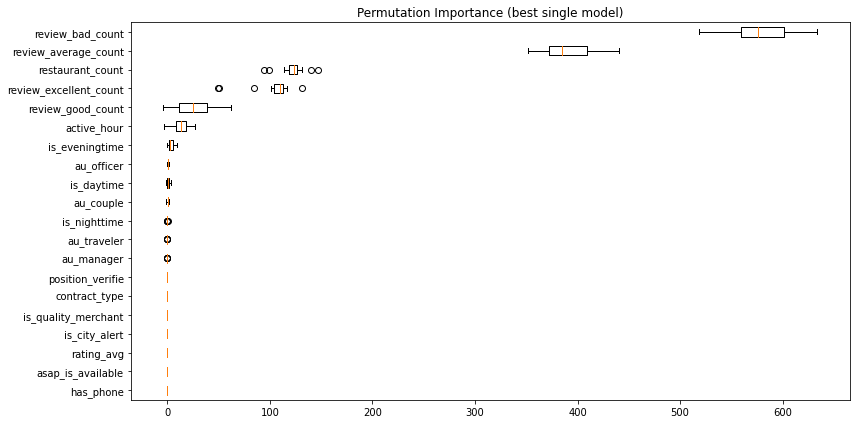

In [406]:
sorted_idx = result.importances_mean.argsort()[-20:]
fig = plt.figure(figsize=(12, 6))
#plt.subplot(1, 1)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=data_X.columns[sorted_idx])
plt.title("Permutation Importance (best single model)")
fig.tight_layout()
plt.show()
     

### Mape

In [272]:
gbr = make_pipeline(preprocess_pipeline,
                        GradientBoostingRegressor(loss='huber', alpha=0.4, 
                                max_depth=4, n_estimators=100,random_state=22))
gbr.fit(train_X, train_y)
val_pred = gbr.predict(val_X)
err_df_temp_2, MAPE, RMSLE = error_stats(val_y, val_pred,is_exp=False)

In [299]:
err_df_temp_2[err_df_temp_2['Relative Error']>10000]['Relative Error'].count()

5

In [298]:
err_df_temp_2[err_df_temp_2['Relative Error']<=10000]['Relative Error'].count()

775

In [295]:
milk_tea_merge.loc[err_df_temp_1[err_df_temp_1['Relative Error']>10000].index]

,address_district,lat,lon,district_type,delivery_avg_price,delivery_has_contract,delivery_merchant_time,delivery_prepare_duration,asap_is_available,has_phone,is_city_alert,is_quality_merchant,contract_type,position_verifie,rating_avg,rating_total_review,promotion_count,average_rating,position_rating,price_rating,quality_rating,service_rating,space_rating,checked_in_count,favourite_count,review_average_count,review_bad_count,review_count,review_excellent_count,review_good_count,view_count,wanted_count,picture_count,active_hour,is_daytime,is_eveningtime,is_nighttime,dish_price,dish_total_order_x,dish_total_like,dish_min_price,dish_max_price,revenue,total_order_new,total_like_new,discount_price_new,price_new,revenue_new,restaurant_count,au_couple,au_family,au_manager,au_officer,au_traveler,au_team,au_student,au_childen,total_order_growth,total_like_growth,revenue_growth,catalog_re_name,dish_name_label,dish_total_order_y
4261,Bình Thạnh,10.806409,106.720038,Nội thành,28294,1,12,12,0,1,0,0,1,0,4.7,1000,16,2.5,3.0,3.0,1.5,2.5,2.5,0,0,0.0,2.0,2.0,0.0,0.0,406.0,0.0,1.0,0.261905,False,False,False,26157.894737,8423.0,604.0,8000.0,78000.0,195862000.0,8424,604,994000.0,994000.0,195897000.0,1.0,True,False,False,False,False,True,True,False,1.0,0.0,35000.0,"Khác, Trà Sữa","Khác, Trà Sữa",8423.0
2910,Quận 2,10.784481,106.746498,Nội thành,48708,1,12,12,0,1,0,0,1,0,4.7,1000,13,6.7,6.7,6.6,6.6,7.0,6.6,2,3,0.0,2.0,7.0,0.0,5.0,798.0,0.0,38.0,0.625000,True,True,False,48708.333333,13699.0,2408.0,29000.0,77000.0,658983000.0,13705,1959,1391500.0,2530000.0,384395000.0,18.0,True,False,False,False,False,True,False,False,6.0,-449.0,-274588000.0,Khác,"Khác, Trà Sữa",13699.0
3811,Quận 12,10.886170,106.652745,Ngoại thành 1,33481,1,5,5,0,1,0,0,1,0,4.2,10,16,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0.0,NaN,NaN,27.0,0.0,0.0,0.541667,True,True,False,29000.000000,0.0,0.0,20000.0,40000.0,0.0,1,0,480001.0,503000.0,30000.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,30000.0,"Khác, Trà Sữa","Khác, Trà Sữa",0.0
6334,Tân Phú,10.812654,106.622350,Nội thành,24316,0,12,12,0,1,0,0,2,0,4.4,10,1,3.8,5.0,5.0,5.0,1.0,3.0,1,0,0.0,1.0,1.0,0.0,0.0,848.0,0.0,6.0,0.583333,True,True,False,21681.818182,485.0,0.0,5000.0,30000.0,11234000.0,486,0,477000.0,477000.0,11256000.0,NaN,False,False,False,True,False,True,True,False,1.0,0.0,22000.0,"Khác, Trà Sữa","Khác, Trà Sữa",485.0
280,Quận 4,10.762684,106.702954,Nội thành,25059,0,12,12,0,1,1,0,2,0,4.7,100,1,7.3,7.7,7.2,7.5,7.8,6.4,2,15,2.0,1.0,13.0,0.0,10.0,1117.0,33.0,89.0,0.291667,False,True,False,25058.823529,2182.0,6.0,12000.0,32000.0,50906000.0,2184,6,426000.0,426000.0,50954000.0,1.0,True,False,False,True,False,True,True,False,2.0,0.0,48000.0,Khác,"Khác, Trà Sữa",2182.0
